cuda


100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


Broj slika za trening: 60000
Broj slika za testiranje: 10000
Broj klasa: 10


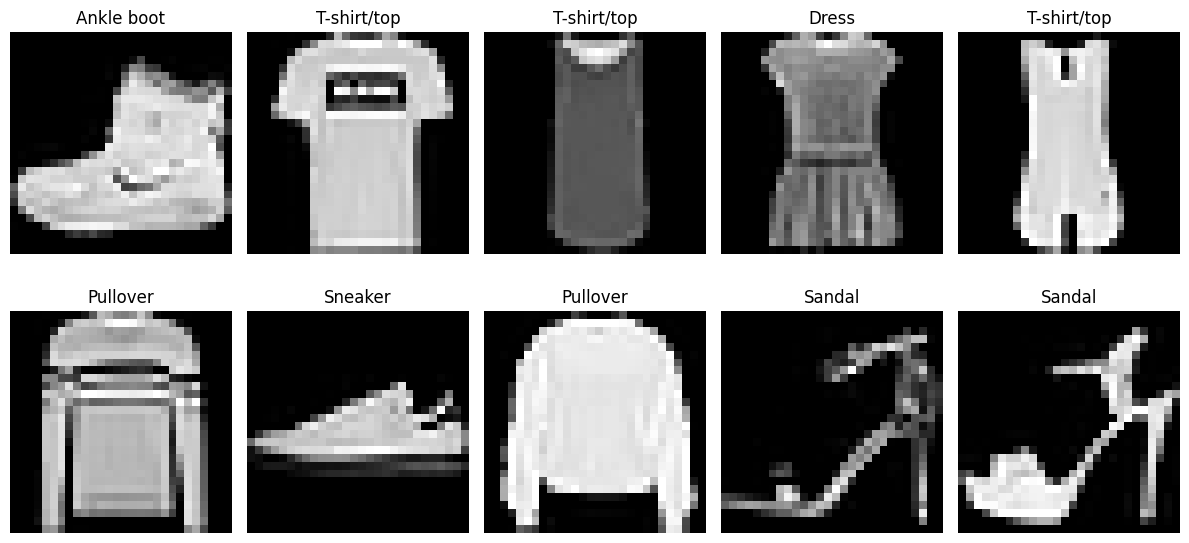

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


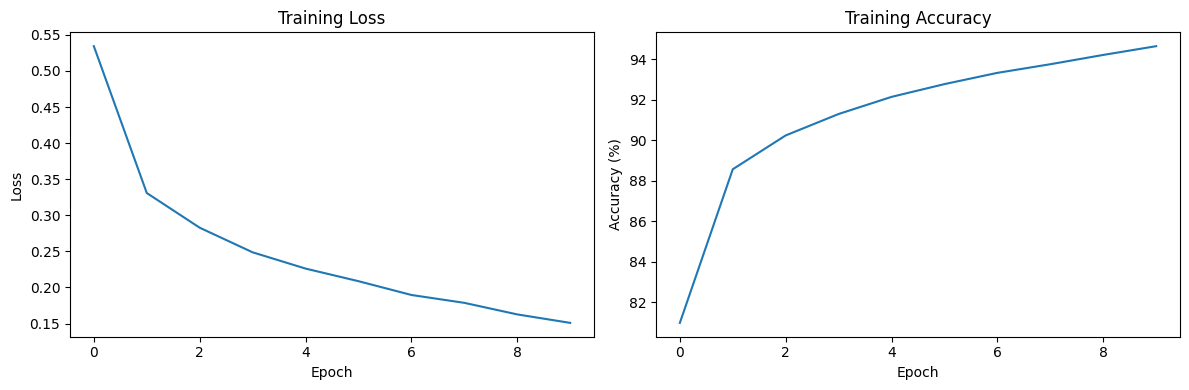


Wrong output:


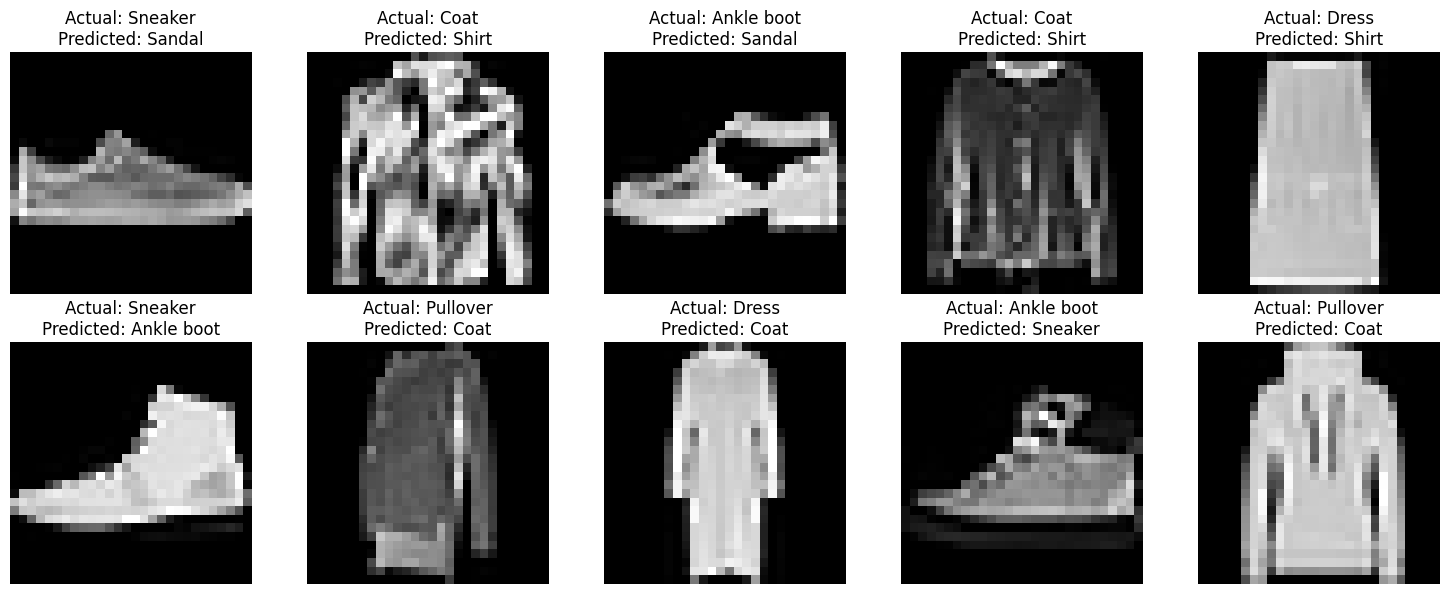

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Necessary data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f'Broj slika za trening: {len(train_dataset)}')
print(f'Broj slika za testiranje: {len(test_dataset)}')
print(f'Broj klasa: {len(class_names)}')

#Showing sample from MNIST Fashion dataset
def show_samples():
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i in range(10):
        img, label = train_dataset[i]
        img = img.squeeze().numpy()

        row = i // 5
        col = i % 5

        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'{class_names[label]}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

show_samples()

#Model architecture
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  #Output for the 10 classes of clothing items we have

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

model = FashionCNN().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall ACC on test set: {overall_accuracy:.2f}%')

    print('\n ACC based on class:')
    for i in range(10):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {accuracy:.2f}%')

    return overall_accuracy

train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
test_accuracy = test_model(model, test_loader)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

def show_misclassified_samples(model, test_loader, num_samples=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            wrong = (predicted != target)
            for i in range(len(wrong)):
                if wrong[i] and len(misclassified) < num_samples:
                    misclassified.append({
                        'image': data[i].cpu(),
                        'predicted': predicted[i].cpu().item(),
                        'actual': target[i].cpu().item()
                    })

            if len(misclassified) >= num_samples:
                break

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, sample in enumerate(misclassified):
        row = i // 5
        col = i % 5

        img = sample['image'].squeeze().numpy()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Actual: {class_names[sample["actual"]]}\n'
                                f'Predicted: {class_names[sample["predicted"]]}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

print("\nWrong output:")
show_misclassified_samples(model, test_loader)